In [531]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import block_diag

sys.path.append(os.path.abspath(os.path.join('../../src')))
sys.path.append(os.path.abspath(os.path.join('../newton_based_algorithms')))

from utils import get_form_initial_conditions
try:
    from tudatpy.astro.time_conversion import DateTime
    use_tudatpy = True
except ImportError:
    print('No tudatpy available')
    use_tudatpy = False
from dynamics import SatelliteDynamics, Propagator

from unkkt import UNKKT
from tree_newton import Tree_Newton
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton

try:
    from concurrent.futures import ProcessPoolExecutor
    use_several_cpus = True
except ImportError:
    print('No concurrent.futures.ProcessPoolExecutor available')
    use_several_cpus = False
use_several_cpus = True

use_causal = False

No tudatpy available


In [532]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 120  # Duration [min]

# Set simulation start (0 TDB seconds since J2000) and end epochs
if use_tudatpy:
    simulation_start_epoch = DateTime(2000, 1, 1).epoch()
    simulation_end_epoch = (T - 1) * dt

T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # State dimension
n_p = 3  
n_y_1 = 3 
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 100 # Window size [min]

In [533]:
# Initial state vector and get the true state vectors
X_initial = get_form_initial_conditions(formation)
if use_tudatpy:
    propagator = Propagator(simulation_start_epoch, simulation_end_epoch, dt, X_initial)
    X_true = propagator.run().T.reshape(24, 1, T)
else:
    X_true = np.zeros((24, 1, T))
    X_true[:, :, 0] = X_initial
    for t in range(T - 1):
        X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

In [534]:
if use_tudatpy:
    # Estimate process noise
    X_our_model = np.zeros((24, 1, T))
    X_our_model[:, :, 0] = X_initial
    for t in range(T - 1):
        X_our_model[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

    # Compute the difference between the ground truth and the model after initial conditions
    diff = X_true[:, :, 1:] - X_our_model[:, :, 1:]
    diff_flattened = diff.T.reshape(-1, 24)

    # Calculate the general covariance matrix of the flattened differences
    Q = np.cov(diff_flattened, rowvar=False)

    # Create a zero matrix of the same shape
    Q_modified = np.zeros_like(Q)

    # Fill only the required block diagonals
    Q_modified[:6, :6] = np.diag(np.diag(Q[:6, :6]))
    Q_modified[6:12, 6:12] = np.diag(np.diag(Q[6:12, 6:12]))
    Q_modified[12:18, 12:18] = np.diag(np.diag(Q[12:18, 12:18]))
    Q_modified[18:, 18:] = np.diag(np.diag(Q[18:, 18:]))
    Q = Q_modified
    pd.DataFrame(Q[:6, :6]), pd.DataFrame(Q[6:12, 6:12]), pd.DataFrame(Q[12:18, 12:18]), pd.DataFrame(Q[18:, 18:])

In [535]:
# propagator2 = Propagator(simulation_start_epoch, simulation_end_epoch, 1.0, X_initial)
# X_true2 = propagator2.run().T.reshape(24, 1, 23641)

# # Estimate process noise
# X_our_model2 = np.zeros((24, 1, 23641))
# X_our_model2[:, :, 0] = X_initial
# for t in range(23641 - 1):
#     X_our_model2[:, :, t + 1] = SatelliteDynamics().x_new(1.0, X_true2[:, :, t])

# # Compute the difference between the ground truth and the model after initial conditions
# diff2 = X_true2[:, :, 1:] - X_our_model2[:, :, 1:]
# diff_flattened2 = diff2.T.reshape(-1, 24)

# # Calculate the general covariance matrix of the flattened differences
# Q2 = np.cov(diff_flattened2, rowvar=False)

# # Create a zero matrix of the same shape
# Q_modified2 = np.zeros_like(Q2)

# # Fill only the required block diagonals
# Q_modified2[:6, :6] = np.diag(np.diag(Q2[:6, :6]))
# Q_modified2[6:12, 6:12] = np.diag(np.diag(Q2[6:12, 6:12]))
# Q_modified2[12:18, 12:18] = np.diag(np.diag(Q2[12:18, 12:18]))
# Q_modified2[18:, 18:] = np.diag(np.diag(Q2[18:, 18:]))
# Q2 = Q_modified2
# pd.DataFrame(Q2[:6, :6]), pd.DataFrame(Q2[6:12, 6:12]), pd.DataFrame(Q2[12:18, 12:18]), pd.DataFrame(Q2[18:, 18:])

In [536]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [537]:
tol = 1e-20
max_iter = 100

# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
# unkkt.grad_tol = tol
# unkkt.max_iter = max_iter

tree_newton = Tree_Newton(W, R_chief, r_deputy_pos)
# tree_newton.grad_tol = tol
# tree_newton.max_iter = max_iter

approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
# approxh_newton.grad_tol = tol
# approxh_newton.max_iter = max_iter

mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
# mm_newton.grad_tol = tol
# mm_newton.max_iter = max_iter
# mm_newton.mm_tol = tol
# mm_newton.mm_max_iter = 1

In [538]:
# Simulation setup
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

In [539]:
if use_several_cpus and use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = X_est  # Centralized Newton
    X_est_tree_newton_history = X_est  # Tree Newton
    X_est_approx_newton_history = X_est  # ApproxH Newton
    X_est_mm_history = X_est  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n - W + 1] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_est[:, :, W - 1]
        X_est_tree_newton = X_est[:, :, W - 1]
        X_est_approx_newton = X_est[:, :, W - 1]
        X_est_mm = X_est[:, :, W - 1]
    
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=3) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Store X_est history per algorithm
            X_est_unkkt_history[:, :, n] = X_est_unkkt
            X_est_tree_newton_history[:, :, n] = X_est_tree_newton
            X_est_approx_newton_history[:, :, n] = X_est_approx_newton
            X_est_mm_history[:, :, n] = X_est_mm
            
            # Propagate the estimated initial conditions until the end of the finite-horizon window
            for i in range(W):
                X_est_unkkt_history[:, :, n] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_history[:, :, n])
                X_est_tree_newton_history[:, :, n] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_history[:, :, n])
                X_est_approx_newton_history[:, :, n] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_history[:, :, n])
                X_est_mm_history[:, :, n] = mm_newton.dynamic_model.x_new(dt, X_est_mm_history[:, :, n])
    
            # Plot results **in the main process**
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))
    
            # Cost function values
            ax1.plot(cost_unkkt, '.-', label='Centralized Newton')
            ax1.plot(cost_tree, '.-', label='Tree Newton')
            ax1.plot(cost_approx, '.-', label='ApproxH Newton')
            ax1.plot(cost_mm, '.-', label='MM Newton Cost Function')
            ax1.plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel(r'$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()
    
            # Gradient norm values
            ax2.plot(grad_unkkt, '.-', label='Centralized Newton')
            ax2.plot(grad_tree, '.-', label='Tree Newton')
            ax2.plot(grad_approx, '.-', label='ApproxH Newton')
            ax2.plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel(r'$\frac{1}{W}$ Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()
    
            fig.suptitle(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

Windows:   0%|          | 0/21 [00:00<?, ?it/s]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 23874560.97493984
Gradient norm: 757202865.335084
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Before applying the algorithm
Cost function: 27668353.906070806
Gradient norm: 758967033.6750062
Global relative error: 395.60563949432424
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m

Before applying the algorithm
L_norm = 27668353.906070806
Grad_L_norm = 758967033.6750062

Iteration 1
Cost function: 12324.097529462611 (-99.95%)
Gradient norm: 1266634.762653959 (-99.83%)
Global relative error: 580.1704740053756 (46.65%)
Position relative errors: 0.03837112171927802 m, 90.65381922807444 m, 90.29404034538499 m, 565.

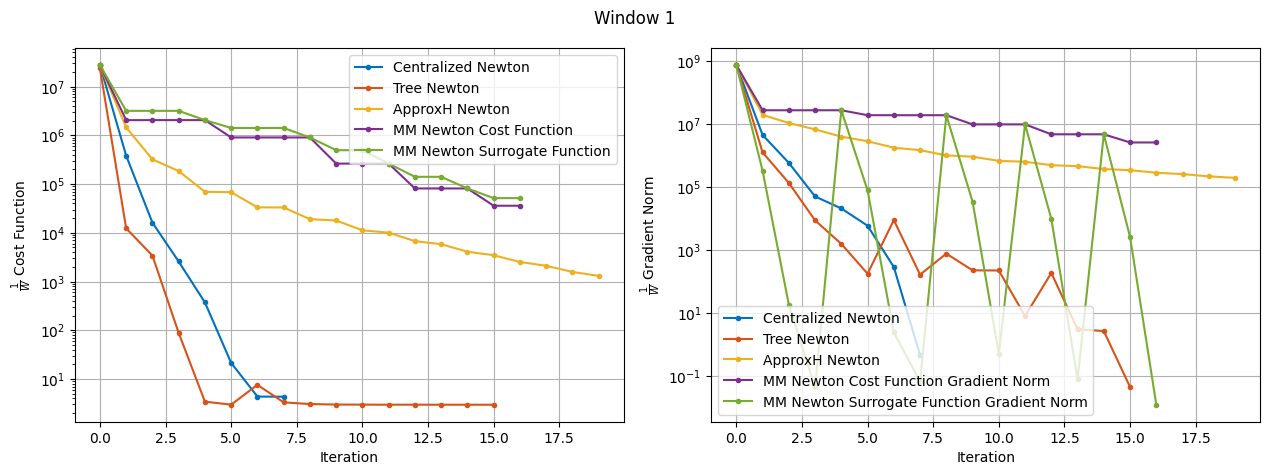


Windows:   5%|▍         | 1/21 [00:52<17:33, 52.67s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
L_norm = 4.3581644649052755
Grad_L_norm = 485.80992928902117

Before applying the algorithm
Cost function: 2.993936882112922
Gradient norm: 393.3074111013398
Global relative error: 41.9032407023996
Position relative errors: 0.058295427802764546 m, 41.89514848470579 m, 0.16837635295734585 m, 0.8018189173401084 m

Before applying the algorithm
Cost function: 1286.9692115763276
Gradient norm: 183693.6100153354
Global relative error: 266.5560212082384
Position relative errors: 0.1260038448140181 m, 147.57945287931224 m, 174.7483350669754 m, 136.8773514083036 m

Iteration 1
Cost function: 2.979647134240448 (-0.48%)
Gradient norm: 39.681054833935754 (-89.91%)
Global relative error: 43.02045808536846 (2.67%)
Position relative errors: 0.05261654179592587 m, 42.99041418561175 m, 1.3540174966408456 m, 

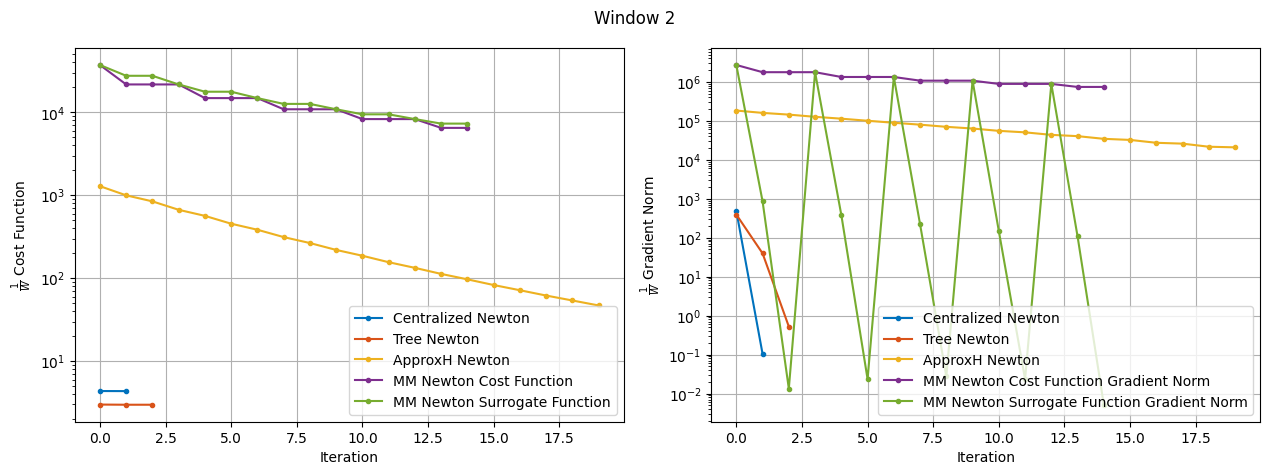


Windows:  10%|▉         | 2/21 [01:38<15:22, 48.56s/it]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton --------


-------- MM Newton --------

Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.9676603272073123
Gradient norm: 1554.4579845508151
Global relative error: 41.07749927222863
Position relative errors: 0.050301283210452206 m, 41.04809643915847 m, 1.2989524308208447 m, 0.8497830359493019 m

Before applying the algorithm
Cost function: 45.51851782304575
Gradient norm: 23662.005758680432
Global relative error: 81.53146251713002
Position relative errors: 0.0415666311399344 m, 41.98599152420843 m, 46.761824794329776 m, 51.94116129709228 m

Before applying the algorithm
L_norm = 4.358140710798794
Grad_L_norm = 1622.6475497973966

Iteration 1
Cost function: 2.948494432576479 (-0.65%)
Gradient norm: 1.8016177519710277 (-99.88%)
Global relative error: 42.51580773719121 (3.50%)
Position relative errors: 0.040377065703033184 m, 42.43716501037352 m, 2.392199061922755 m,

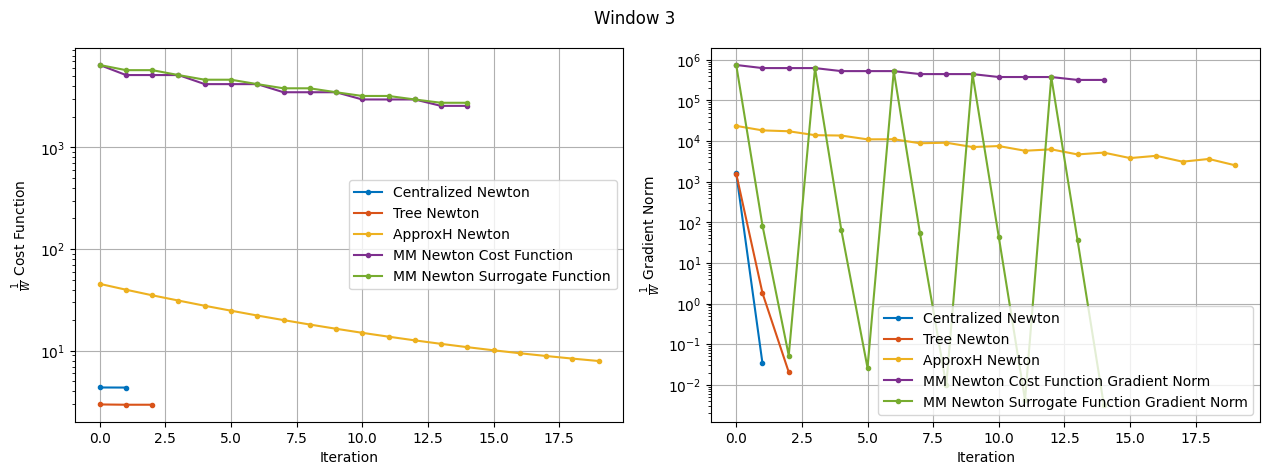


Windows:  14%|█▍        | 3/21 [02:24<14:12, 47.37s/it]

-------- ApproxH Newton ---------------- Tree Newton ---------------- Centralized Newton --------


-------- MM Newton --------

Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.967116099733595
Gradient norm: 1779.4157886995797
Global relative error: 39.49402578044521
Position relative errors: 0.03875471713124945 m, 39.40627607088565 m, 2.447147608374043 m, 0.9646273046661885 m

Before applying the algorithm
Cost function: 8.036782472988046
Gradient norm: 3148.8983488823183
Global relative error: 26.889987605500085
Position relative errors: 0.03508178615573648 m, 12.924113795340666 m, 17.298197539877854 m, 16.025279740750435 m

Before applying the algorithm
L_norm = 4.40042423086582
Grad_L_norm = 1850.4054726555032

Iteration 1
Cost function: 2.96281073125672 (-0.15%)
Gradient norm: 11.610549608543606 (-99.35%)
Global relative error: 33.68525180011457 (-14.71%)
Position relative errors: 0.03875812496599583 m, 33.635226301686835 m, 1.6142221009574236 

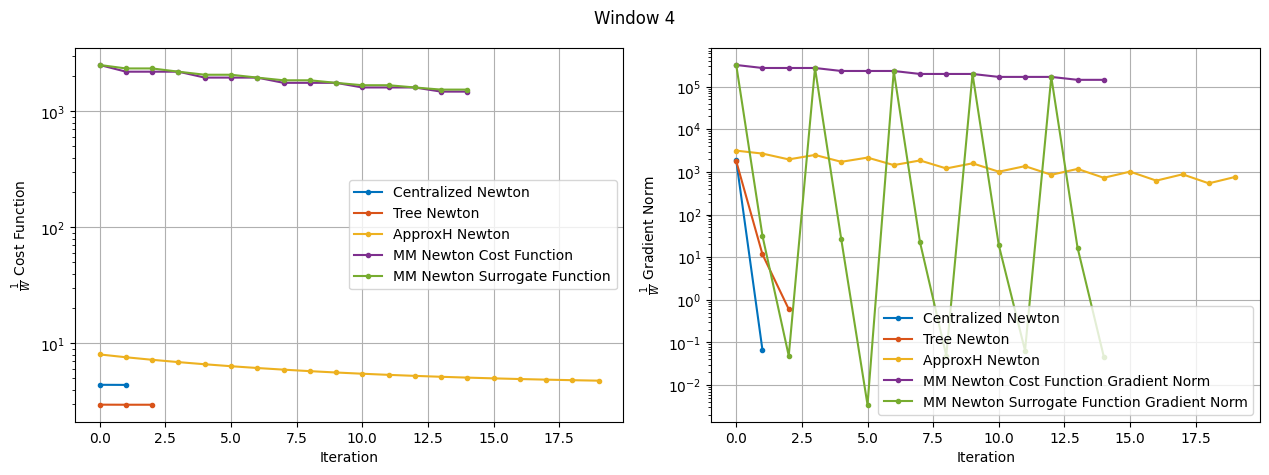


Windows:  19%|█▉        | 4/21 [03:09<13:13, 46.67s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------
-------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
L_norm = 4.439436428640533
Grad_L_norm = 2463.812862625761

Before applying the algorithm
Cost function: 2.978042414730427
Gradient norm: 2263.8391888287506
Global relative error: 30.024232231358667
Position relative errors: 0.03728483364137703 m, 29.9672941565142 m, 1.6546843129309023 m, 0.8204031098275665 m

Before applying the algorithm
Cost function: 4.876532956514557
Gradient norm: 2867.1008031197207
Global relative error: 8.66114012830927
Position relative errors: 0.03568190899508887 m, 3.2992184206945434 m, 5.199537985695263 m, 6.090483186404837 m

STOP on Iteration 1
L_norm = 4.429031121504424
Grad_L_norm = 0.051082389530788655

Final position relative errors: [0.0369039968545904, 0.6631515149469704, 0.7020975476486604, 0.44041538362419697] m
Iteration 1
Cost function: 2.9750367703603

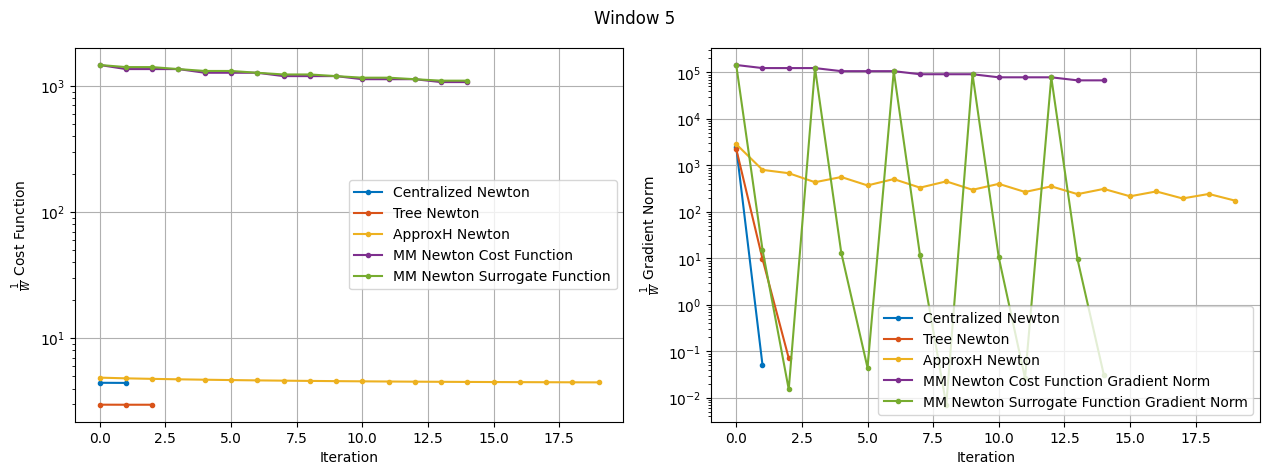


Windows:  24%|██▍       | 5/21 [03:56<12:23, 46.49s/it]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton --------
-------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.954661475686446
Gradient norm: 170.59045330604857
Global relative error: 28.12065514151625
Position relative errors: 0.03542498670772787 m, 28.006598204595818 m, 2.3525275353503066 m, 0.9289378789373857 m

Before applying the algorithm
Cost function: 4.458191047565871
Gradient norm: 351.71824055824777
Global relative error: 2.5100840969711466
Position relative errors: 0.034842370280768996 m, 0.6127214751793385 m, 1.290106768321748 m, 2.0638543105161533 m

Before applying the algorithm
L_norm = 4.412807992312156
Grad_L_norm = 253.04471686133874

Iteration 1
Cost function: 2.952782226890337 (-0.06%)
Gradient norm: 4.1475417654634175 (-97.57%)
Global relative error: 30.806434355827307 (9.55%)
Position relative errors: 0.025541056328775725 m, 30.554611877706048 m, 3.7847875407335

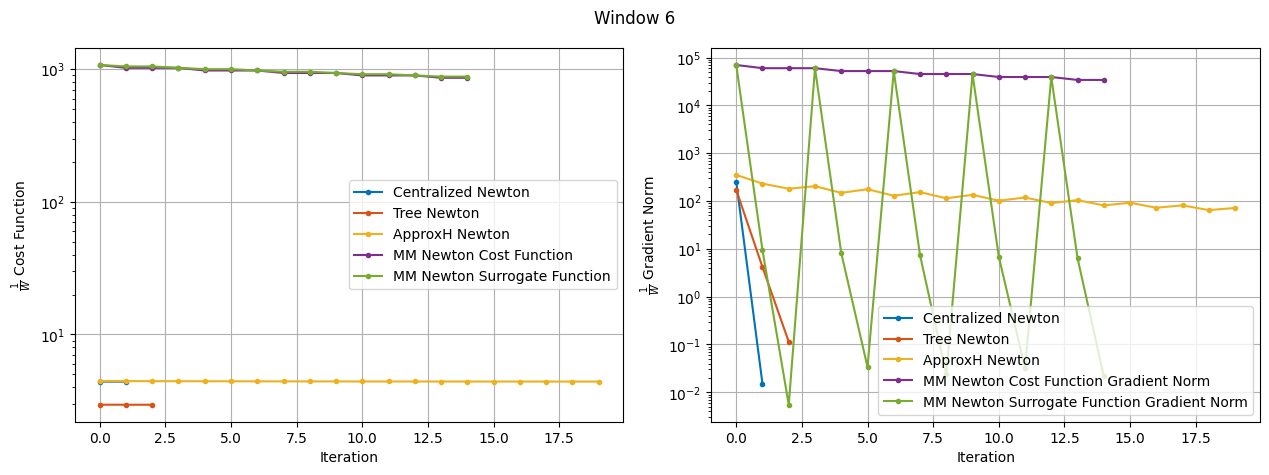


Windows:  29%|██▊       | 6/21 [04:42<11:37, 46.48s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------
-------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 4.365555652528312
Gradient norm: 2348.2947383424716
Global relative error: 1.066993153886086
Position relative errors: 0.024332780856888152 m, 0.17593597971827463 m, 0.3635476449542086 m, 0.9872978794710985 m

Before applying the algorithm
Cost function: 2.9443294191360696
Gradient norm: 2306.445401867135
Global relative error: 26.808878009488666
Position relative errors: 0.02454438471447518 m, 26.519952858201098 m, 3.786061980695398 m, 1.0341897618874398 m

Before applying the algorithm
L_norm = 4.363937521572215
Grad_L_norm = 2337.6827653354294

Iteration 1
Cost function: 2.930550498878462 (-0.47%)
Gradient norm: 28.537891528139706 (-98.76%)
Global relative error: 28.016613041841445 (4.50%)
Position relative errors: 0.01925165305463298 m, 27.556981378164423 m, 5.0309238205704

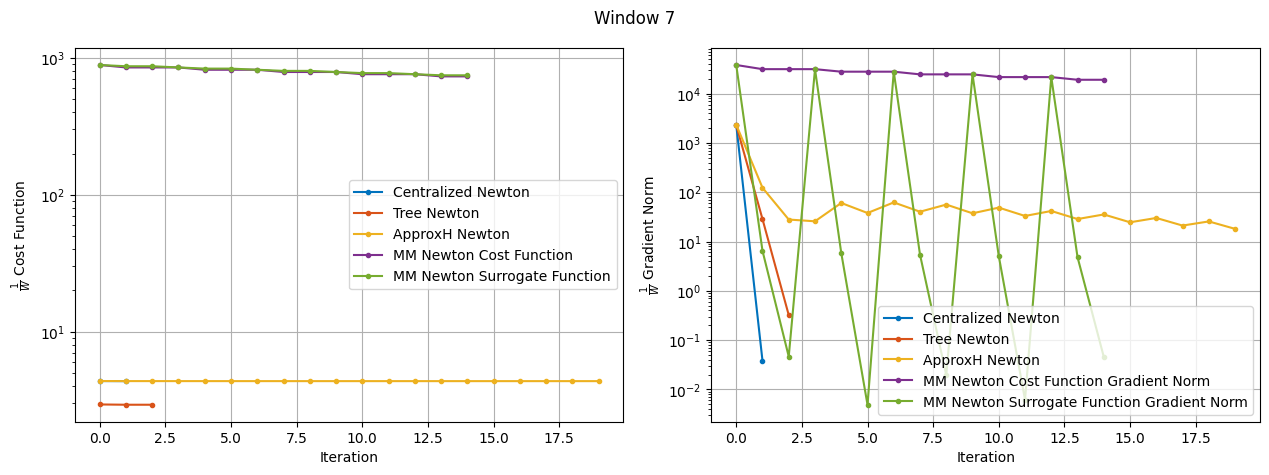


Windows:  33%|███▎      | 7/21 [05:28<10:47, 46.25s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.88505677866491
Gradient norm: 3222.4480348900306
Global relative error: 23.035429019374156
Position relative errors: 0.019332952745946604 m, 22.55214278607523 m, 4.670727482684724 m, 0.4591389309916897 m

Before applying the algorithm
Cost function: 4.274649535737665
Gradient norm: 3144.219206365049
Global relative error: 1.0728877258829501
Position relative errors: 0.019290560571025205 m, 0.1981980563703996 m, 0.6192427208796819 m, 0.8532108019180482 m

Before applying the algorithm
L_norm = 4.274255179769908
Grad_L_norm = 3148.0116830755487

Iteration 1
Cost function: 2.8680156105465864 (-0.59%)
Gradient norm: 15.673722171459081 (-99.51%)
Global relative error: 22.529879075189722 (-2.19%)
Position relative errors: 0.027637703311313728 m, 21.48254327716962 m, 6.7171962656091

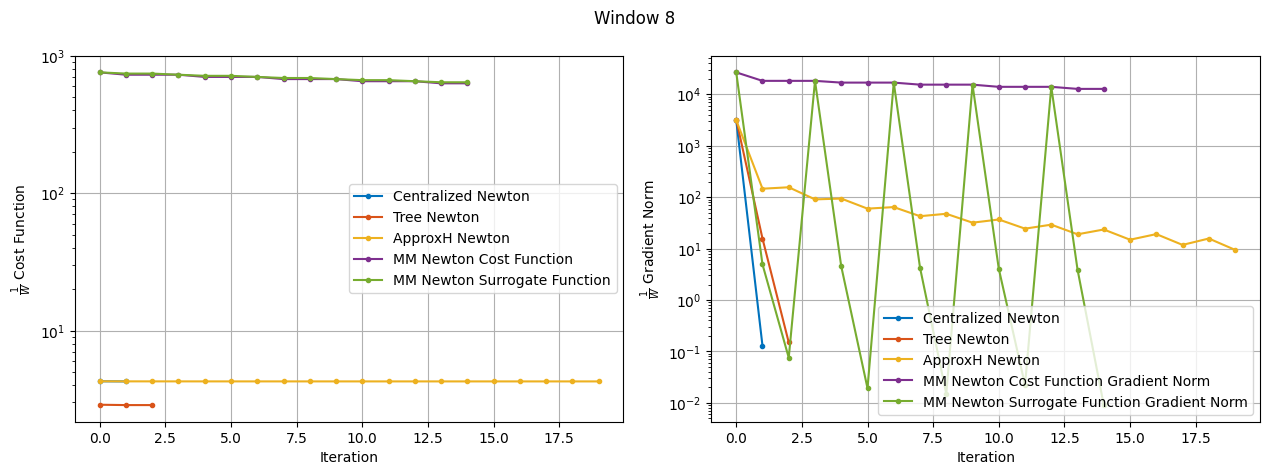


Windows:  38%|███▊      | 8/21 [06:15<10:04, 46.50s/it]

-------- ApproxH Newton ---------------- Centralized Newton ---------------- Tree Newton --------


-------- MM Newton --------

Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.863567672836694
Gradient norm: 417.4522175397574
Global relative error: 18.47697979532388
Position relative errors: 0.027659852448837986 m, 17.075697839390713 m, 6.997235991350695 m, 0.9234714876798051 m

Before applying the algorithm
Cost function: 4.285087214567906
Gradient norm: 823.4628054924868
Global relative error: 0.910347555851957
Position relative errors: 0.027632356467535236 m, 0.15939044412744008 m, 0.5521081542466116 m, 0.7055043968288083 m

Before applying the algorithm
L_norm = 4.284725817195971
Grad_L_norm = 829.6890112695619

Iteration 1
Cost function: 2.8602644140038804 (-0.12%)
Gradient norm: 13.438785996446294 (-96.78%)
Global relative error: 21.743357757364333 (17.68%)
Position relative errors: 0.027151122669298332 m, 17.901802848707472 m, 12.293007062356

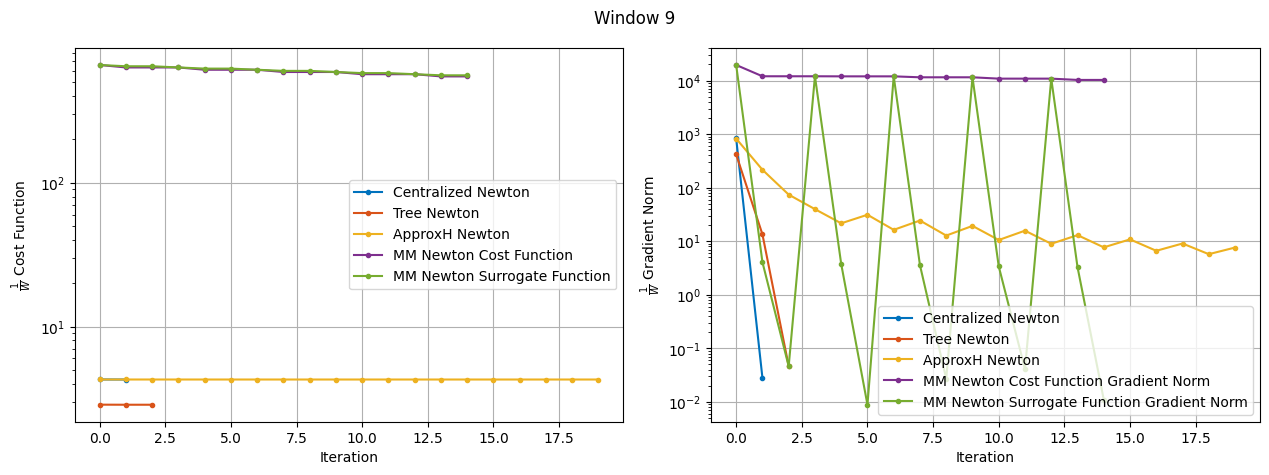


Windows:  43%|████▎     | 9/21 [07:00<09:12, 46.07s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


-------- MM Newton --------

Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.876739970448038
Gradient norm: 2207.5020373724665
Global relative error: 18.9056900691485
Position relative errors: 0.027083918798977907 m, 14.530420373471232 m, 12.051489706706601 m, 1.024178761316196 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=4.70809e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Before applying the algorithm
Cost function: 4.27357198008097
Gradient norm: 2037.9786779386816
Global relative error: 0.867948263341056
Position relative errors: 0.02706689133873071 m, 0.2367297769952756 m, 0.6656700499610688 m, 0.5034284245679342 m

Before applying the algorithm
L_norm = 4.273625470507606
Grad_L_norm = 2035.7969668989442

Iteration 1
Cost function: 5.362520391058665 (86.41%)
Gradient norm: 7737.140343954253 (250.49%)
Global relative error: 128.7373308741616 (580.94%)
Position relative errors: 0.027171884771779422 m, 128.66329394146445 m, 4.326047764088893 m, 0.5774771029880966 m

Iteration 1
Cost function: 4.271372523726414 (-0.05%)
Gradient norm: 97.01405310663021 (-95.24%)
Global relative error: 0.9532326406814925 (9.83%)
Position relative errors: 0.02701031919907648 m, 0.21342193836571596 m, 0.8123441645646642 m, 0.4499634127850712 m

Before applying the algorithm
Cost function: 570.4305816940789
Gradient norm: 14996.86814258536
Global relative error: 202.97068727

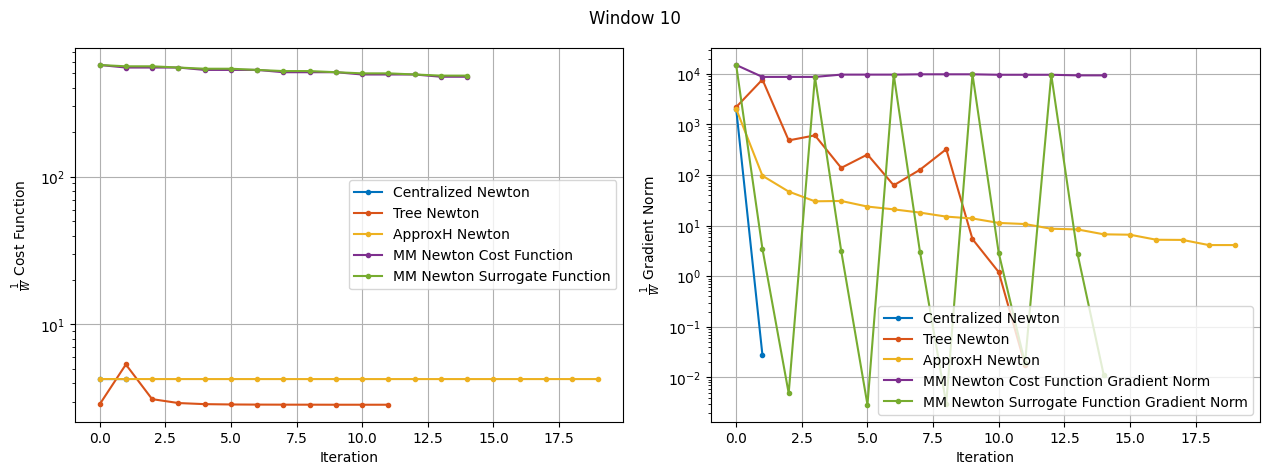


Windows:  48%|████▊     | 10/21 [07:46<08:28, 46.19s/it]

-------- Tree Newton --------
-------- Centralized Newton ---------------- ApproxH Newton ---------------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.8696016071466577
Gradient norm: 1644.4053357191199
Global relative error: 5.489469394943633
Position relative errors: 0.02700207099694201 m, 3.4497096047772486 m, 4.23634400099635 m, 0.5296893054397656 m

Before applying the algorithm
Cost function: 4.275870583776965
Gradient norm: 1726.6277450274104
Global relative error: 0.9757245399671178Before applying the algorithm
L_norm = 4.2758709246890305
Grad_L_norm = 1725.9351940182241


Position relative errors: 0.027003377502174186 m, 0.09319598255391538 m, 0.7986698655675546 m, 0.5520389293366555 m

Iteration 1
Cost function: 2.86497869875982 (-0.16%)
Gradient norm: 71.48045481074018 (-95.65%)
Global relative error: 8.410462277447687 (53.21%)
Position relative errors: 0.02864054144467417 m, 8.272007084820181 m, 1.412416229633828

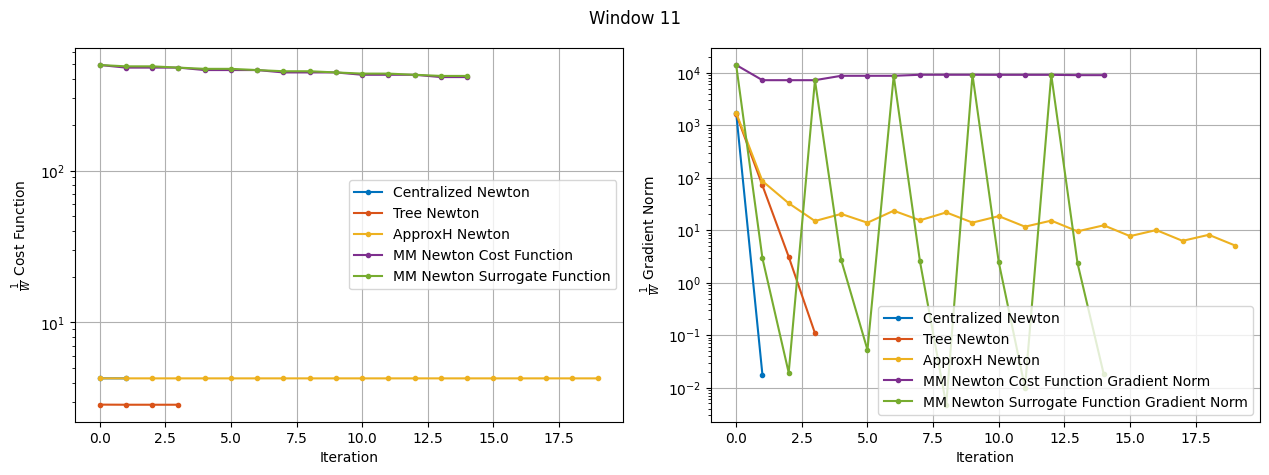


Windows:  52%|█████▏    | 11/21 [08:32<07:39, 45.99s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 4.289215045339316
Gradient norm: 837.3334231640688
Global relative error: 0.8978138588360248
Position relative errors: 0.02833101617754893 m, 0.12903792686347224 m, 0.786488138293012 m, 0.4123708220546994 m

Before applying the algorithm
Cost function: 2.873490671303154
Gradient norm: 715.3684612721772
Global relative error: 7.069586010457467
Position relative errors: 0.02834096892584098 m, 6.905934048512955 m, 1.4226627800963971 m, 0.5077815948758662 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.12344e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Before applying the algorithm
L_norm = 4.289182225542929
Grad_L_norm = 836.2435409325325

Iteration 1
Cost function: 8.038550034410498 (179.75%)
Gradient norm: 12872.778407043366 (1699.46%)
Global relative error: 143.95271909561507 (1936.23%)
Position relative errors: 0.0300928999178983 m, 143.93926997638906 m, 1.9602216211816244 m, 0.15416903865281012 m

Iteration 1
Cost function: 4.286263367205715 (-0.07%)
Gradient norm: 184.03237376939498 (-78.02%)
Global relative error: 0.8335900907295734 (-7.15%)
Position relative errors: 0.0300501703455812 m, 0.1764258326553897 m, 0.6863579482312964 m, 0.437896409045969 m

Before applying the algorithm
Cost function: 430.6648381872341
Gradient norm: 11446.121857682676
Global relative error: 173.97806301327765STOP on Iteration 1
L_norm = 4.285100597410419
Grad_L_norm = 0.07739614258809979


Final position relative errors: [0.030094390033248996, 0.09903406532172081, 0.6433438353978489, 0.4344612757181748] mPosition relative errors: 0.05747857756364

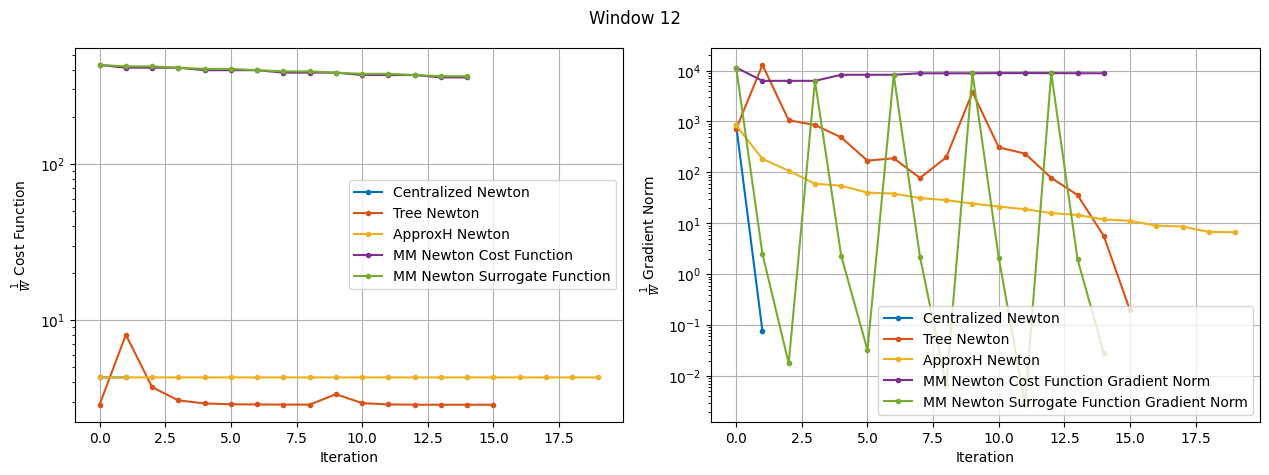


Windows:  57%|█████▋    | 12/21 [09:18<06:54, 46.01s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.837867456761405
Gradient norm: 695.4447029493414
Global relative error: 11.038168700448455
Position relative errors: 0.02970189402573659 m, 10.87780149417322 m, 1.8689587109763546 m, 0.11902526684257717 m

Before applying the algorithm
L_norm = 4.283787495088874
Grad_L_norm = 698.3574531808922
Before applying the algorithm
Cost function: 4.283816050684825
Gradient norm: 700.1180903529904
Global relative error: 0.784526449546949

Position relative errors: 0.02969857489941936 m, 0.08816795510233756 m, 0.615924754838681 m, 0.4769284067422776 m

Iteration 1
Cost function: 2.8313641077975094 (-0.23%)
Gradient norm: 1.0213385407062443 (-99.85%)
Global relative error: 10.35669677007941 (-6.17%)
Position relative errors: 0.02352403463976959 m, 9.853017230731863 m, 3.1408056404183498 

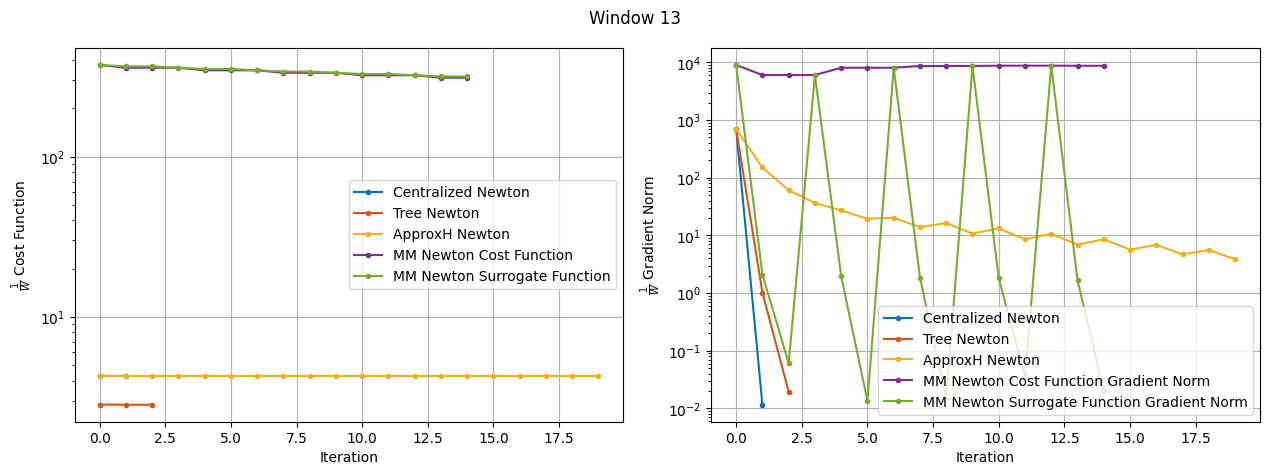


Windows:  62%|██████▏   | 13/21 [10:04<06:06, 45.86s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.862376845143659
Gradient norm: 5689.666759120994
Global relative error: 14.911409282150672
Position relative errors: 0.023093765586542296 m, 14.601240356586393 m, 2.982494378674402 m, 0.5015189088496527 m

Before applying the algorithm
L_norm = 4.315101222933032
Grad_L_norm = 5761.51767976882

Before applying the algorithm
Cost function: 4.315103958311496
Gradient norm: 5762.131228526282
Global relative error: 0.8308320250712601
Position relative errors: 0.023082411016311557 m, 0.14715214816224534 m, 0.7304639694242633 m, 0.3667631343308957 m

Iteration 1
Cost function: 2.8594524925507 (-0.10%)
Gradient norm: 257.4490074069594 (-95.48%)
Global relative error: 31.65284753408455 (112.27%)
Position relative errors: 0.026695312321245446 m, 31.530100134034257 m, 2.674692994595319 

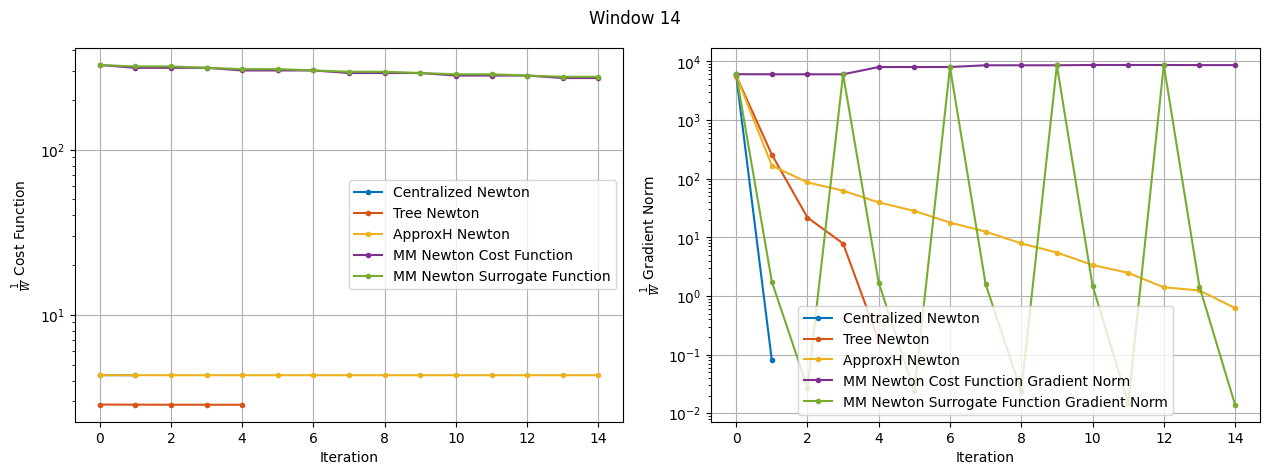


Windows:  67%|██████▋   | 14/21 [10:50<05:21, 45.89s/it]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton --------


-------- MM Newton --------

Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.8422636759437876
Gradient norm: 1554.2057423507504
Global relative error: 28.635303953850137
Position relative errors: 0.026077007645309874 m, 28.51363155426271 m, 2.526047972950309 m, 0.7513825424242225 m

Before applying the algorithm
Cost function: 4.299358218459976
Gradient norm: 1532.8220817681618
Global relative error: 0.811556314565974
Position relative errors: 0.026074747209903017 m, 0.27723201722606383 m, 0.660153418052635 m, 0.38115737065750166 m

Before applying the algorithm
L_norm = 4.299365142515197
Grad_L_norm = 1532.8027541100714

Iteration 1
Cost function: 2.8388785348246355 (-0.12%)
Gradient norm: 4.6276539979926214 (-99.70%)
Global relative error: 30.07942165647267 (5.04%)
Position relative errors: 0.03163174413862337 m, 29.995757236035324 m, 1.967204384393

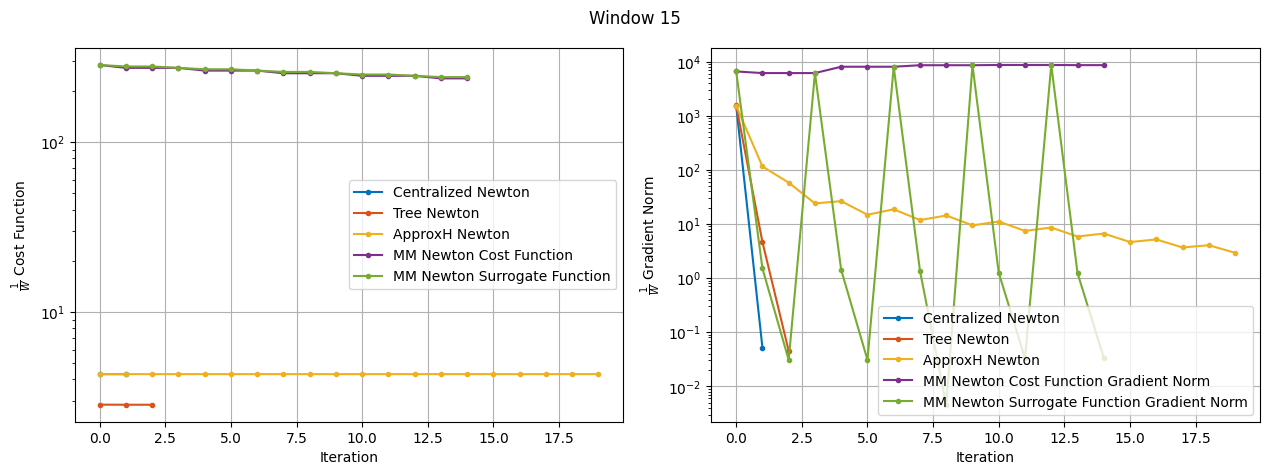


Windows:  71%|███████▏  | 15/21 [11:35<04:35, 45.89s/it]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton --------


-------- MM Newton --------

Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.8205795888236644
Gradient norm: 1031.1490256081302
Global relative error: 35.071848980528216
Position relative errors: 0.030731753033368506 m, 35.00629651662494 m, 1.8531945680414008 m, 1.0729624923869374 m

Before applying the algorithm
Cost function: 4.25733279167323
Gradient norm: 1015.7498095918642
Global relative error: 0.9622829119506298
Position relative errors: 0.030738992708859967 m, 0.3961021933365015 m, 0.6929249440416984 m, 0.5366553489339191 m

Before applying the algorithm
L_norm = 4.257300393937955
Grad_L_norm = 1015.3184949697627

Iteration 1
Cost function: 2.946366194451024 (4.46%)
Gradient norm: 2330.863840668649 (126.05%)
Global relative error: 84.55142234998046 (141.08%)
Position relative errors: 0.027366241034438576 m, 84.54081231467966 m, 0.7925007728078

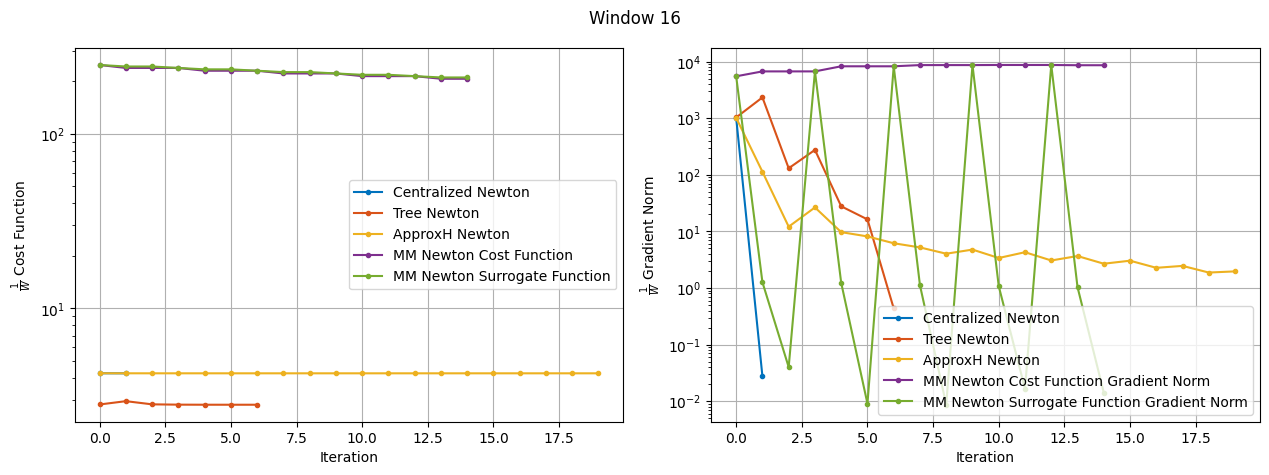


Windows:  76%|███████▌  | 16/21 [12:21<03:49, 45.83s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------
-------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.8320657031179177
Gradient norm: 3066.120125789919
Global relative error: 55.471501546618136
Position relative errors: 0.026321304528089905 m, 55.454849483757144 m, 0.7501954947404547 m, 1.1293402283194531 m

Before applying the algorithm
Cost function: 4.260315840885858
Gradient norm: 3059.7842218074156
Global relative error: 0.8504290103500874
Position relative errors: 0.026325942395699763 m, 0.37848392498067596 m, 0.42619146759514104 m, 0.6305912713341949 m

Before applying the algorithm
L_norm = 4.2603127033510875
Grad_L_norm = 3059.6667207365113

Iteration 1
Cost function: 2.825964523143636 (-0.22%)
Gradient norm: 112.17800154582979 (-96.34%)
Global relative error: 45.53062056844705 (-17.92%)
Position relative errors: 0.02806630532755435 m, 45.51131536823682 m, 0.81418060

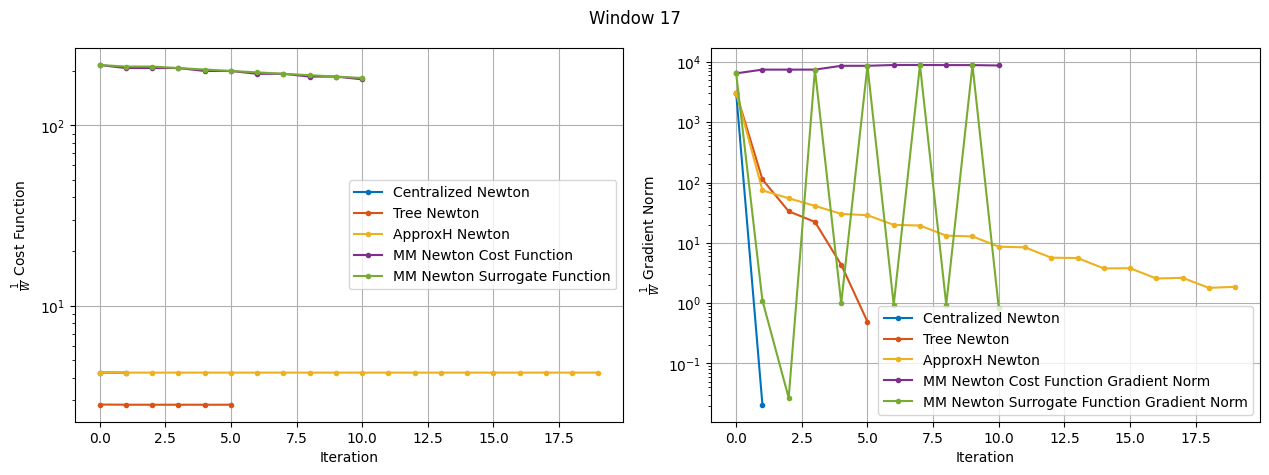


Windows:  81%|████████  | 17/21 [12:55<02:49, 42.30s/it]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton --------
-------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.823677351944809
Gradient norm: 2165.7846940260292
Global relative error: 36.34725673171056
Position relative errors: 0.027072344047469506 m, 36.322190979982096 m, 0.7895728596821174 m, 1.0917679226208965 m

Before applying the algorithm
Cost function: 4.2342547603809155
Gradient norm: 2165.230316431309
Global relative error: 0.9166857237493619
Position relative errors: 0.027076112503126862 m, 0.3582763202273522 m, 0.5389432136524971 m, 0.648656832508329 m

Before applying the algorithm
L_norm = 4.2342547744174155
Grad_L_norm = 2165.3725521386523

Iteration 1
Cost function: 2.81681763041053 (-0.24%)
Gradient norm: 13.18601109443592 (-99.39%)
Global relative error: 32.5022166324855 (-10.58%)
Position relative errors: 0.03245241391233707 m, 32.47947090395538 m, 0.748884755171481

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.10445e-16): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 1
Cost function: 4.230331137623154 (-0.09%)
Gradient norm: 122.44413568525178 (-94.34%)
Global relative error: 0.8496001973428289 (-7.32%)
Position relative errors: 0.03299423184969641 m, 0.30961021529969973 m, 0.5890286635404008 m, 0.5271778497696291 m

STOP on Iteration 1
L_norm = 4.228649438731183
Grad_L_norm = 0.06130346508257438

Final position relative errors: [0.03245341647068697, 0.40121280556915634, 0.5697011272767586, 0.6863561855516017] m
Before applying the algorithm
Cost function: 188.85818067266325
Gradient norm: 7163.61158412659
Global relative error: 97.66752395863988
Position relative errors: 0.055751216354892864 m, 4.511432035288721 m, 68.18194931254745 m, 69.7839125363957 m

Iteration 2
Cost function: 2.8168046213213818 (-0.00%)
Gradient norm: 6.688377242621821 (-49.28%)
Global relative error: 29.721307449000598 (-8.56%)
Position relative errors: 0.032452410539661296 m, 29.696438683675293 m, 0.7486284893581233 m, 0.9544305292016233 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=8.55851e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 2
Cost function: 4.229562630435377 (-0.02%)
Gradient norm: 44.117172481945026 (-63.97%)
Global relative error: 0.8970379258087077 (5.58%)
Position relative errors: 0.03279546144185056 m, 0.3256158116827956 m, 0.5262430609972076 m, 0.6485690714336048 m

STOP on Iteration 3
Cost function = 2.8168030606292316 (-0.00%)
Gradient norm = 0.9318694892595825 (-86.07%)
Global relative error = 28.67495989341039 (-3.52%)
Final position relative errors: 0.03245240703592384 m, 28.64918253044348 m, 0.74862848548152 m, 0.9544304979883468 m

Iteration 3
Cost function: 4.2291717019688235 (-0.01%)
Gradient norm: 53.22197378827182 (20.64%)
Global relative error: 0.8833979441821008 (-1.52%)
Position relative errors: 0.032683939487228884 m, 0.3510472736322516 m, 0.5656215960246208 m, 0.5797927955805698 m

STOP on Iteration 1
Cost function = 185.08915126273266 (-2.00%)
Gradient norm = 0.9233751675525559 (-99.99%)
Global relative error = 96.08919008165329 (-1.62%)
Final position relative errors: 0.0

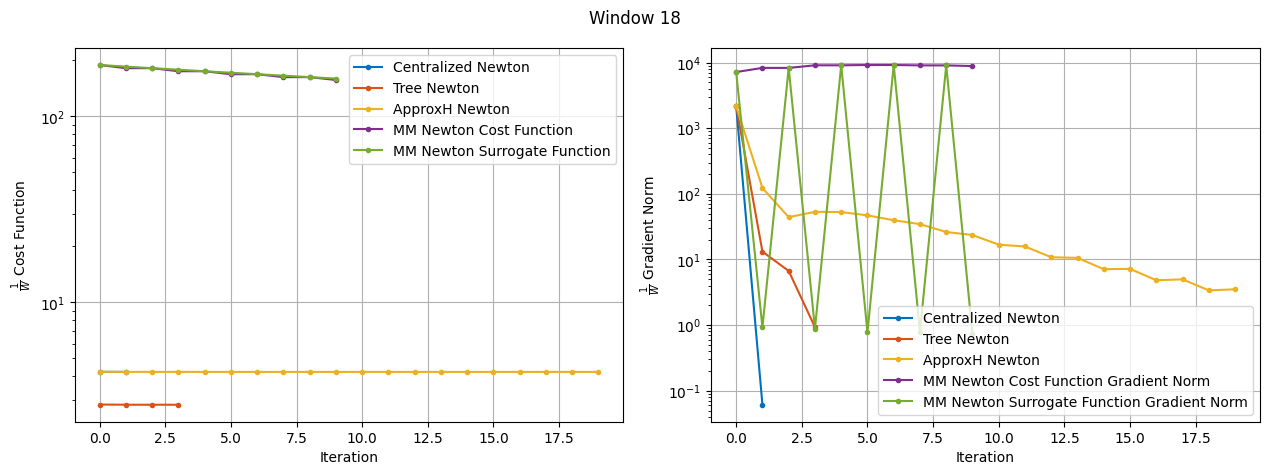


Windows:  86%|████████▌ | 18/21 [13:26<01:56, 38.91s/it]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton --------
-------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.8479150183399446
Gradient norm: 2336.9657110778767
Global relative error: 32.94450496750107
Position relative errors: 0.03109127302814367 m, 32.91972108606172 m, 0.7741384103204506 m, 1.0135102257937083 m

Before applying the algorithm
Cost function: 4.25252380230358
Gradient norm: 2334.173877955454
Global relative error: 1.0307638257861893
Position relative errors: 0.031095933437389218 m, 0.457773060137387 m, 0.5824712176211396 m, 0.7160142396574299 m

Before applying the algorithm
L_norm = 4.252557089535627
Grad_L_norm = 2334.269813744534

Iteration 1
Cost function: 2.8415674064957397 (-0.22%)
Gradient norm: 10.064454375658867 (-99.57%)
Global relative error: 29.558388727247234 (-10.28%)
Position relative errors: 0.027888475295317065 m, 29.535999935016918 m, 0.6755245130081

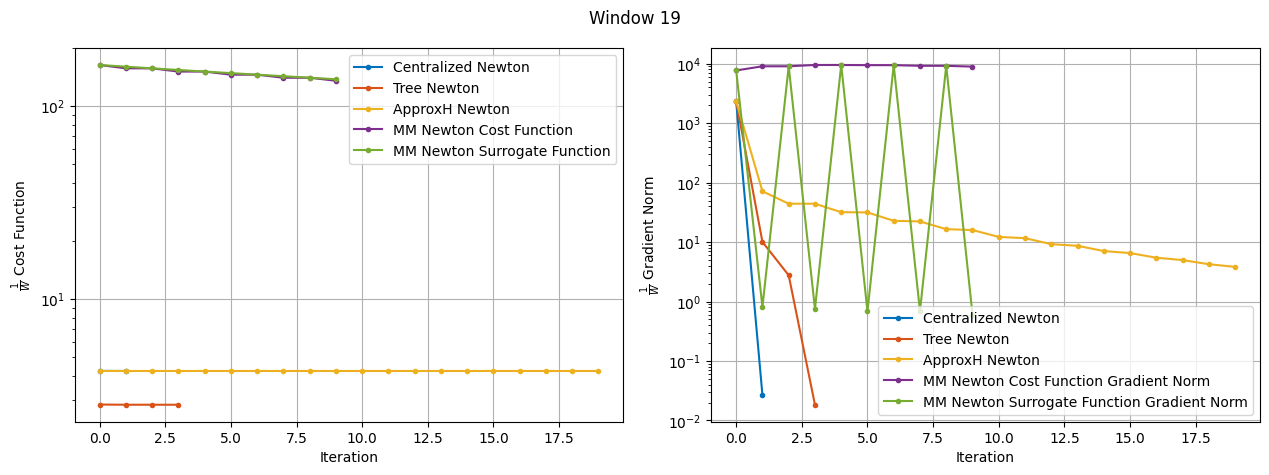


Windows:  90%|█████████ | 19/21 [13:57<01:13, 36.61s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton ---------------- MM Newton --------




Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 4.220193400728454
Gradient norm: 321.69635023629263
Global relative error: 0.9698343830481744Before applying the algorithm
L_norm = 4.220213141497576
Grad_L_norm = 321.9253999954736


Position relative errors: 0.026571255249387273 m, 0.335892767475539 m, 0.5668981703633441 m, 0.7111073790293865 m

Before applying the algorithm
Cost function: 2.8284308160830887
Gradient norm: 341.0166687625126
Global relative error: 32.03942463386993
Position relative errors: 0.026577490426848715 m, 32.016934742953275 m, 0.6784940579147481 m, 0.9873881820479353 m

Iteration 1
Cost function: 2.8240886832481804 (-0.15%)
Gradient norm: 185.61418951835174 (-45.57%)
Global relative error: 42.03193889010703 (31.19%)
Position relative errors: 0.040218540709662375 m, 42.013240738945 m, 0.536952381318347

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=1.06309e-16): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 4
Cost function: 4.215825075266978 (-0.00%)
Gradient norm: 60.31031944669825 (-30.29%)
Global relative error: 1.0903645914014157 (-1.39%)
Position relative errors: 0.040301422253755194 m, 0.46153491248086603 m, 0.5705866955435972 m, 0.8054102202427758 m

STOP on Iteration 5
Cost function = 2.823626183725511 (-0.00%)
Gradient norm = 0.13218671360446338 (-94.46%)
Global relative error = 52.22090583133041 (0.74%)
Final position relative errors: 0.04021854152557478 m, 52.20584968594479 m, 0.5369516391258926 m, 1.1307504663974781 m

Iteration 5
Cost function: 4.215770586563962 (-0.00%)
Gradient norm: 49.21604911843738 (-18.40%)
Global relative error: 1.1148524320969804 (2.25%)
Position relative errors: 0.04028774654751012 m, 0.470006939589282 m, 0.5564814376468711 m, 0.8430262286942471 m

Before applying the algorithm
Cost function: 134.67650417786845
Gradient norm: 9599.164591004639
Global relative error: 73.0349945909075
Position relative errors: 0.06654581136525928 m, 1.6570977

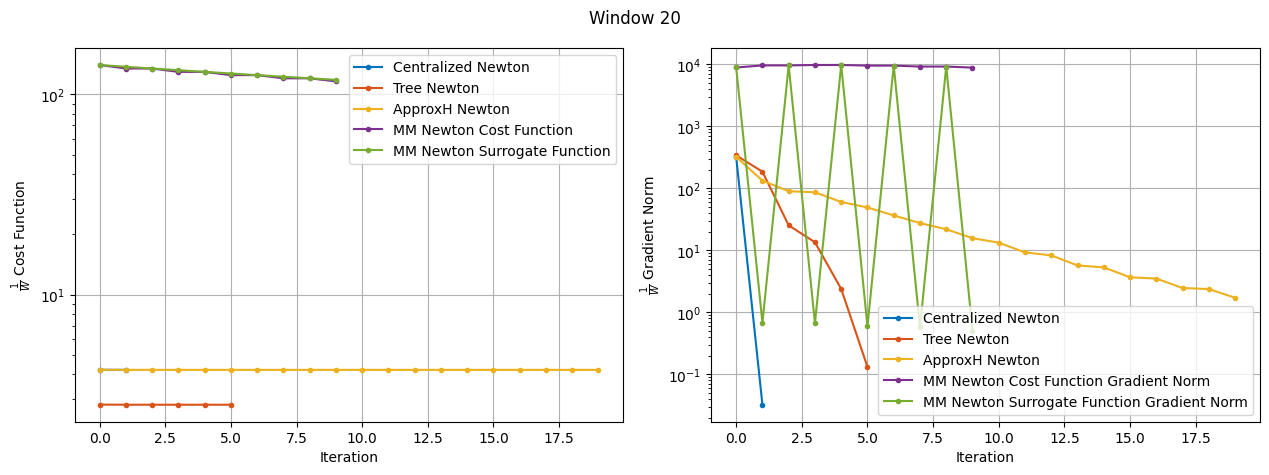


Windows:  95%|█████████▌| 20/21 [14:28<00:34, 34.80s/it]

-------- Centralized Newton ---------------- ApproxH Newton ---------------- Tree Newton --------
-------- MM Newton --------



Majorization-Minimization Iteration 1
Before applying the algorithm
Cost function: 2.86034511115356
Gradient norm: 861.9037877593278
Global relative error: 55.76491563859436
Position relative errors: 0.038414265005295184 m, 55.74958154175951 m, 0.5595564337392037 m, 1.179883594021708 m

Before applying the algorithm
Cost function: 4.25137038497982
Gradient norm: 876.0070636183038
Global relative error: 1.1783637660671422
Position relative errors: 0.03841552421363197 m, 0.5434624372722435 m, 0.5803939576713182 m, 0.8688242357048485 m

Before applying the algorithm
L_norm = 4.2513509778827805
Grad_L_norm = 876.5831583396774

Iteration 1
Cost function: 2.853083999481604 (-0.25%)
Gradient norm: 63.83274191650561 (-92.59%)
Global relative error: 60.86849855648841 (9.15%)
Position relative errors: 0.04295727012342293 m, 60.85170103062992 m, 0.6409454487917442 m, 1.

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:411: LinAlgWarning: Ill-conditioned matrix (rcond=6.25702e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 1
Cost function: 4.246888282841554 (-0.11%)
Gradient norm: 198.90413307297106 (-77.29%)
Global relative error: 1.310078524777164 (11.18%)
Position relative errors: 0.043524725019474506 m, 0.8065682896131348 m, 0.4876141291625073 m, 0.9088952057483403 m

STOP on Iteration 1
L_norm = 4.2448792195965
Grad_L_norm = 0.2429763469135771

Final position relative errors: [0.042959151052389045, 0.9464393043171495, 0.6298030747231241, 1.0895245915469307] m
Before applying the algorithm
Cost function: 119.74891774884355
Gradient norm: 9802.817265034717
Global relative error: 63.29544741885207
Position relative errors: 0.059555741165090464 m, 2.067744196412251 m, 41.090442760862246 m, 48.099827055661805 m

Iteration 2
Cost function: 2.900059898920512 (1.65%)
Gradient norm: 2366.3414033172426 (3607.10%)
Global relative error: 10.359932115752592 (-82.98%)
Position relative errors: 0.042957193462820654 m, 10.260776355304735 m, 0.6409077314459839 m, 1.2757140303034384 m

Iteration 2
Cost func

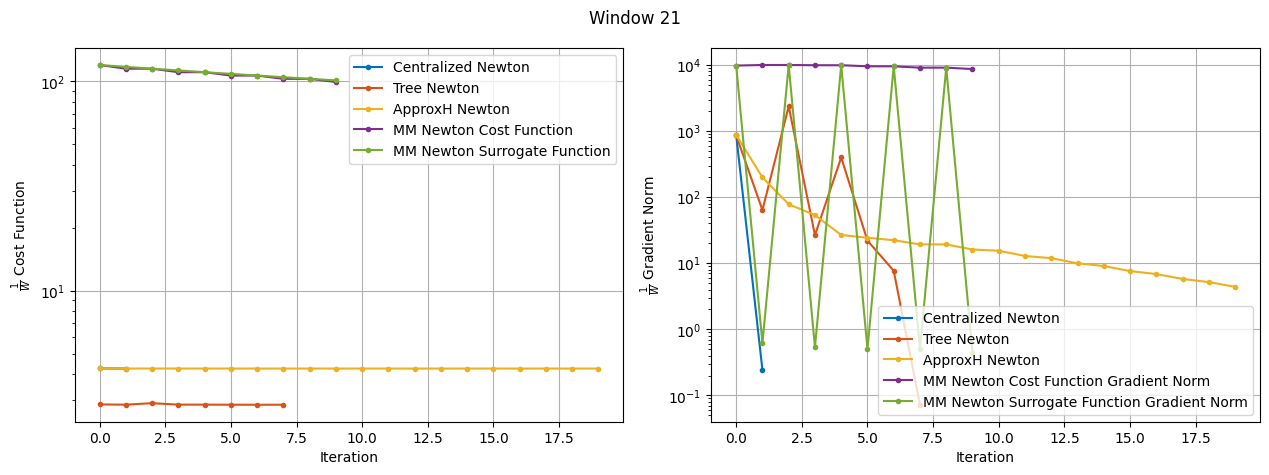


MC runs: 100%|██████████| 1/1 [15:00<00:00, 900.15s/it] 


In [540]:
if use_several_cpus and not use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = np.zeros((24, 1, K))  # Centralized Newton
    X_est_tree_newton_history = np.zeros((24, 1, K))  # Tree Newton
    X_est_approx_newton_history = np.zeros((24, 1, K))  # ApproxH Newton
    X_est_mm_history = np.zeros((24, 1, K))  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W], X_true[:, :, n])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
    
        for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=4) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Store X_est history per algorithm
            X_est_unkkt_history[:, :, n] = X_est_unkkt
            X_est_tree_newton_history[:, :, n] = X_est_tree_newton
            X_est_approx_newton_history[:, :, n] = X_est_approx_newton
            X_est_mm_history[:, :, n] = X_est_mm
    
            # Plot results **in the main process**
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))
    
            # Cost function values
            ax1.plot(cost_unkkt, '.-', label='Centralized Newton')
            ax1.plot(cost_tree, '.-', label='Tree Newton')
            ax1.plot(cost_approx, '.-', label='ApproxH Newton')
            ax1.plot(cost_mm, '.-', label='MM Newton Cost Function')
            ax1.plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel(r'$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()
    
            # Gradient norm values
            ax2.plot(grad_unkkt, '.-', label='Centralized Newton')
            ax2.plot(grad_tree, '.-', label='Tree Newton')
            ax2.plot(grad_approx, '.-', label='ApproxH Newton')
            ax2.plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel(r'$\frac{1}{W}$ Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()
    
            fig.suptitle(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

In [541]:
if not use_several_cpus:
    # SEQUENTIAL USING ONE CPU
    # Main execution loop
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

        # Estimate the state
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False): # n is the index of the end of the finite-horizon window
            print("-------- Centralized Newton --------")
            X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n - W + 1 : n + 1])
            print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n - W + 1] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est_unkkt[18:21])} m")
            print("-------- Tree Newton --------")
            X_est_tree_newton = tree_newton.solve_for_each_window(dt, X_est_tree_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- ApproxH Newton --------")
            X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- MM Newton --------")
            X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

            # First subplot - Cost function values
            ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
            ax1.plot(tree_newton.cost_function_values, '.-', label='Tree Newton')
            ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
            ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
            ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('$\frac{1}{W}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()

            # Second subplot - Gradient norm values
            ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
            ax2.plot(tree_newton.grad_norm_values, '.-', label='Tree Newton')
            ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
            ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('$\frac{1}{W}$Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()

            plt.title(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
            
            unkkt.cost_function_values = []
            unkkt.grad_norm_values = []
            tree_newton.cost_function_values = []
            tree_newton.grad_norm_values = []
            approxh_newton.cost_function_values = []
            approxh_newton.grad_norm_values = []
            mm_newton.cost_function_values = []
            mm_newton.grad_norm_values = []
            mm_newton.surrogate_function_values = []
            mm_newton.surrogate_grad_norm_values = []
            
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

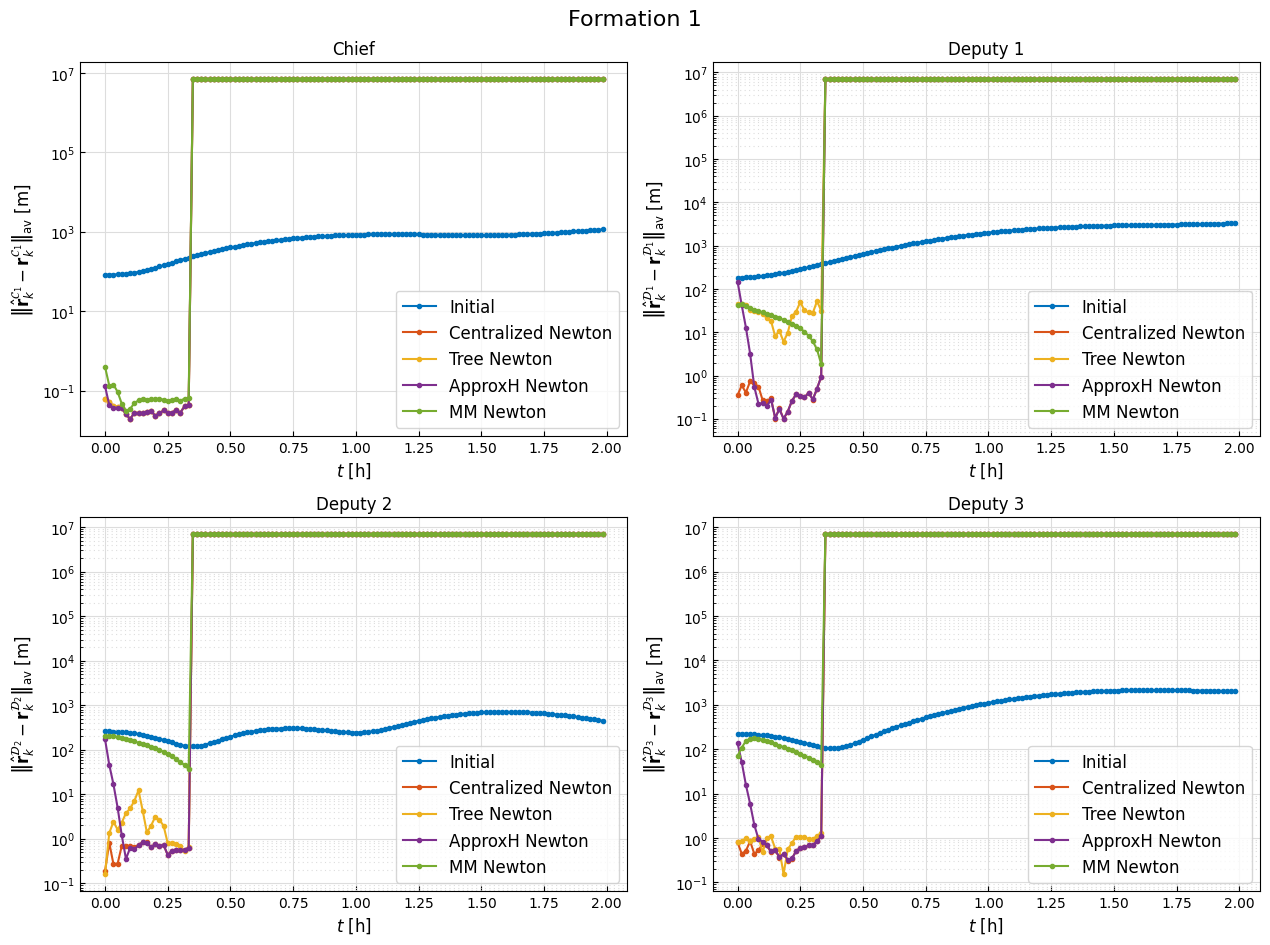

In [542]:
# Compute norm of absolute position deviation for each agent and each algorithm
def compute_position_deviation(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

# Extract deviations for Chief and Deputies
dev_chief_unkkt, dev_deputy1_unkkt, dev_deputy2_unkkt, dev_deputy3_unkkt = compute_position_deviation(X_est_unkkt_history, X_true)
dev_chief_tree, dev_deputy1_tree, dev_deputy2_tree, dev_deputy3_tree = compute_position_deviation(X_est_tree_newton_history, X_true)
dev_chief_approx, dev_deputy1_approx, dev_deputy2_approx, dev_deputy3_approx = compute_position_deviation(X_est_approx_newton_history, X_true)
dev_chief_mm, dev_deputy1_mm, dev_deputy2_mm, dev_deputy3_mm = compute_position_deviation(X_est_mm_history, X_true)

# Time array
T = X_true.shape[2]

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", label="Initial")
axs[0, 0].plot(time, dev_chief_unkkt, ".-", label="Centralized Newton")
axs[0, 0].plot(time, dev_chief_tree, ".-", label="Tree Newton")
axs[0, 0].plot(time, dev_chief_approx, ".-", label="ApproxH Newton")
axs[0, 0].plot(time, dev_chief_mm, ".-", label="MM Newton")
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{C}_1} - \\mathbf{r}_k^{\\mathcal{C}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)
axs[0, 0].set_title("Chief")

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", label="Initial")
axs[0, 1].plot(time, dev_deputy1_unkkt, ".-", label="Centralized Newton")
axs[0, 1].plot(time, dev_deputy1_tree, ".-", label="Tree Newton")
axs[0, 1].plot(time, dev_deputy1_approx, ".-", label="ApproxH Newton")
axs[0, 1].plot(time, dev_deputy1_mm, ".-", label="MM Newton")
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_1} - \\mathbf{r}_k^{\\mathcal{D}_1}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)
axs[0, 1].set_title("Deputy 1")

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", label="Initial")
axs[1, 0].plot(time, dev_deputy2_unkkt, ".-", label="Centralized Newton")
axs[1, 0].plot(time, dev_deputy2_tree, ".-", label="Tree Newton")
axs[1, 0].plot(time, dev_deputy2_approx, ".-", label="ApproxH Newton")
axs[1, 0].plot(time, dev_deputy2_mm, ".-", label="MM Newton")
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_2} - \\mathbf{r}_k^{\\mathcal{D}_2}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)
axs[1, 0].set_title("Deputy 2")

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", label="Initial")
axs[1, 1].plot(time, dev_deputy3_unkkt, ".-", label="Centralized Newton")
axs[1, 1].plot(time, dev_deputy3_tree, ".-", label="Tree Newton")
axs[1, 1].plot(time, dev_deputy3_approx, ".-", label="ApproxH Newton")
axs[1, 1].plot(time, dev_deputy3_mm, ".-", label="MM Newton")
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{r}}_k^{\\mathcal{D}_3} - \\mathbf{r}_k^{\\mathcal{D}_3}\\right\\|_\\mathrm{av}$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)
axs[1, 1].set_title("Deputy 3")

fig.suptitle(f"Formation {formation}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()